In [ ]:
#Darshan Parsana
#gmail: darshanparsanadap@gmail.com

#first, I will implement the ACO then GA.

In [363]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import random
np.random.seed(2019)
%matplotlib inline

In [ ]:
#Ant Colony Implementation for TSP

In [253]:
class Graph(object):
    def __init__(self, adj_mat = [], random_generate=True, sparsity=0.5, num_nodes=7, high=5):
        
        self.amat = np.array(adj_mat)
        if random_generate: self._create_random_graph(sparsity=sparsity, high=high, num_nodes=num_nodes)
        self.pheromone = np.array([[1/num_nodes**2 for j in range(num_nodes)] for i in range(num_nodes)])                                                   #tau
        self.n_nodes = num_nodes

        
    def _create_random_graph(self, high=5, num_nodes=7, sparsity=0.5):
    
        mat = np.zeros((num_nodes,num_nodes))
        for r in range(0,num_nodes):
            for c in range(0, r+1):
                distance = np.random.randint(1, high+1)

                if np.random.random()<sparsity or r==c: distance = 0
                    
                mat[r,c] = distance
                mat[c,r] = distance

        self.amat = mat
    
    def _make_label_dict(self, labels = list):
        label_dict = {}
        for i, label in enumerate(labels):
            label_dict[i] = label
        return label_dict
    
    def draw_citymap(self):
        mat = self.amat
        bG = nx.DiGraph(mat)
        labels= self._make_label_dict(range(0,7))
        edge_labels = dict( ((u, v), int(d["weight"])) for u, v, d in bG.edges(data=True) )
        pos = nx.spring_layout(bG)
        nx.draw(bG, pos)
        nx.draw_networkx_edge_labels(bG, pos, edge_labels=edge_labels)
        nx.draw(bG,pos,node_size=500, labels=labels, with_labels=True)
        

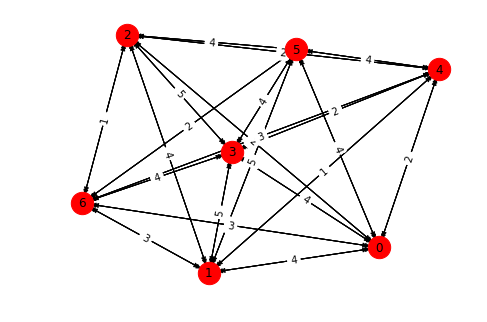

In [848]:
graph = Graph(sparsity=0)
graph.draw_citymap()

In [850]:
#Ant Colony
class AC(object): 
    def __init__(self, beta=10, p=0.5, tot_ant= 10, iteration= 1, alpha= 1,  q=1):
        self.q = q                            # pheromone intensity
        self.p = p                            # pheromone trail decay coefficient 
        self.alpha = alpha                    # relative importance of pheromone
        self.beta = beta                      # relative importance of heuristic information
        self.M = tot_ant
        self.iteration = iteration

    def _pheromone_update(self, ants:list, graph:Graph):
        for ant in ants:
            for i in range(1, len(ant.visited_path)):
                prev_node = ant.visited_path[i-1]
                next_node = ant.visited_path[i]
                graph.pheromone[prev_node][next_node] += self.q / ant.get_objective_fun_val()
                graph.pheromone[next_node][prev_node] += self.q / ant.get_objective_fun_val()  #since it is transpose
                
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= (1 - self.p)
        
            
    
    def _construct_solution(self, ant, graph):
            for i in range(graph.n_nodes-1):
                ant.select_next_node()
            ant.travel_cost += graph.amat[ant.visited_path[0]][ant.visited_path[-1]]
            
    
    def run(self, graph:Graph):
        min_cost = float('inf')
        best_solution = []
        
        for _ in range(self.iteration):
            ants = [Ant(self, graph) for i in range(self.M)]
            
            for ant in ants:
                self._construct_solution(ant, graph)
            self._pheromone_update(ants, graph)
                    
            if ant.travel_cost < min_cost:
                min_cost = ant.travel_cost
                best_solution = ant.visited_path
        
            if not _ % 20: print(_, min_cost, best_solution)
        return min_cost, best_solution
                           

In [852]:
#Ant
class Ant(object):
    def __init__(self, colony:AC, graph:Graph):
        self.current = np.random.randint(0, graph.n_nodes) 
        self.allowed_nodes = np.array([i for i in range(graph.n_nodes)])
        self.colony = colony
        self.travel_cost = 0
        self.graph = graph
        self.delta_pheromone = 1
        self.visited_path = [self.current]
        
        self.allowed_nodes = self.allowed_nodes[self.allowed_nodes != self.current]
        
        self.dist_to_next_nodes = {}
        self.previous = -1
        for i in self.allowed_nodes:
            self.dist_to_next_nodes[i] = self.graph.amat[self.current][i]
    
    def select_next_node(self):
        denominator = 0.0
        for i in self.allowed_nodes:
            denominator += (self.graph.pheromone[self.current][i]**self.colony.alpha)*(self.dist_to_next_nodes[i]**self.colony.beta)
        prob = {}
        
        for i in self.dist_to_next_nodes:
            temp =  (self.graph.pheromone[self.current][i] ** self.colony.alpha * self.dist_to_next_nodes[i] ** self.colony.beta)
            prob[i] = (self.graph.pheromone[self.current][i] ** self.colony.alpha * self.dist_to_next_nodes[i] ** self.colony.beta) / denominator
    
        selected_node = [self.current]
        if len(prob.keys()):
            selected_node = np.random.choice(list(prob.keys()),1,p=list(prob.values()))
        self._update_to_next_node(selected_node[0])
        
    def _update_to_next_node(self, next_node):
        
        self.travel_cost += self.graph.amat[self.current][next_node]
        self.previous = self.current
        
        self.current = next_node
        
#         self.allowed.remove(next_node)                                         #todo check this
        index = np.argwhere(self.allowed_nodes==next_node)
        self.allowed_nodes = np.delete(self.allowed_nodes, index)
        
        self.visited_path.append(self.current)
        
        self.dist_to_next_nodes = {}
        for i in self.allowed_nodes:
            self.dist_to_next_nodes[i] = self.graph.amat[self.current][i]
      
    def get_objective_fun_val(self):
        return self.travel_cost
    

In [855]:
cost_matrix = []
ac = AC(iteration=1550, tot_ant=50, p=0.8)

In [856]:
cost, path = ac.run(g)

0 21.0 [5, 0, 6, 2, 1, 4, 3]
20 19.0 [3, 0, 6, 4, 1, 2, 5]
40 19.0 [3, 0, 6, 4, 1, 2, 5]
60 19.0 [3, 0, 6, 4, 1, 2, 5]
80 19.0 [3, 0, 6, 4, 1, 2, 5]
100 19.0 [3, 0, 6, 4, 1, 2, 5]
120 19.0 [3, 0, 6, 4, 1, 2, 5]


/home/dap/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


140 19.0 [3, 0, 6, 4, 1, 2, 5]
160 18.0 [0, 6, 2, 1, 5, 3, 4]
180 18.0 [0, 6, 2, 1, 5, 3, 4]
200 18.0 [0, 6, 2, 1, 5, 3, 4]
220 18.0 [0, 6, 2, 1, 5, 3, 4]
240 18.0 [0, 6, 2, 1, 5, 3, 4]
260 18.0 [0, 6, 2, 1, 5, 3, 4]
280 18.0 [0, 6, 2, 1, 5, 3, 4]
300 18.0 [0, 6, 2, 1, 5, 3, 4]
320 18.0 [0, 6, 2, 1, 5, 3, 4]
340 18.0 [0, 6, 2, 1, 5, 3, 4]
360 18.0 [0, 6, 2, 1, 5, 3, 4]
380 18.0 [0, 6, 2, 1, 5, 3, 4]
400 18.0 [0, 6, 2, 1, 5, 3, 4]
420 18.0 [0, 6, 2, 1, 5, 3, 4]
440 18.0 [0, 6, 2, 1, 5, 3, 4]
460 18.0 [0, 6, 2, 1, 5, 3, 4]
480 18.0 [0, 6, 2, 1, 5, 3, 4]
500 18.0 [0, 6, 2, 1, 5, 3, 4]
520 18.0 [0, 6, 2, 1, 5, 3, 4]
540 18.0 [0, 6, 2, 1, 5, 3, 4]
560 18.0 [0, 6, 2, 1, 5, 3, 4]
580 18.0 [0, 6, 2, 1, 5, 3, 4]
600 18.0 [0, 6, 2, 1, 5, 3, 4]
620 18.0 [0, 6, 2, 1, 5, 3, 4]
640 18.0 [0, 6, 2, 1, 5, 3, 4]
660 18.0 [0, 6, 2, 1, 5, 3, 4]
680 18.0 [0, 6, 2, 1, 5, 3, 4]
700 18.0 [0, 6, 2, 1, 5, 3, 4]
720 18.0 [0, 6, 2, 1, 5, 3, 4]
740 18.0 [0, 6, 2, 1, 5, 3, 4]
760 18.0 [0, 6, 2, 1, 5, 3, 4]
780 18.0

In [ ]:
# Genetic Implementation for TSP

In [857]:
class Chromosome(object):
    def __init__(self,  graph=None ,genes=[], random_initialize=True):
        self.fitness = 0.0
        self.travel_cost = 0
        self.genes = genes
        self.graph = graph
        if random_initialize: self._random_initialize()
        if graph: self._update_cost_params()
        
    def __len__(self):
        return len(self.genes)
    
    def __str__(self):
        print(self.genes)
        return ''
            
    def _random_initialize(self):
        self.genes = np.random.permutation(self.graph.n_nodes)
    
    def calculate_fitness(self):
        self.fitness = 1 / self.travel_cost
        return self.fitness
    
    def _update_cost_params(self):
        self.travel_cost = 0
        self.fitness = 0
            
        for i in range(len(self.genes)-1):
            first_gene = self.genes[i]
            next_gene = self.genes[i+1]
            self.travel_cost += self.graph.amat[first_gene][next_gene]
        self.travel_cost += self.graph.amat[self.genes[0]][self.genes[-1]]
        self.calculate_fitness()
        
    def swap_genes(self, index1, index2):
        self.genes[index1], self.genes[index2] = self.genes[index2], self.genes[index1]
        self._update_cost_params()

    def mutate(self, mu_rate):
        for i in range(len(self)):
            if np.random.random() < mu_rate:
                swap_index = random.sample(self.genes, 2)
                self.swap_genes(swap_index[0], swap_index[1])

In [858]:
class Population(object):
    
    def __init__(self, chromosomes:list):
        self.chromosomes = chromosomes
        
    def __len__(self):
        return len(self.chromosomes)
    
    def __str__(self):
        for i in self.chromosomes:
            print(i)
        return ''
        
    def add(self, chromosome):
        self.chromosomes.append(chromosome)
        
    def remove(self, chromosome):
        self.chromosomes.remove(chromosome)
    
    def get_fittest(self):
        if len(self.chromosomes): 
            fittest = self.chromosomes[0]
            for chromosome in self.chromosomes:
                if chromosome.fitness > fittest.fitness:
                    fittest = chromosome
            return chromosome
        

In [924]:
class Nature(object):
    def __init__(self, population:Population, iteration=50, mu_rate=0.2, tsize=7):
        self.population = population
        self.cost_history = [self.population.get_fittest().travel_cost]
        self.iteration = iteration
        self.tsize = tsize
        self.mu_rate = mu_rate
        self.max_pop_size =  len(self.population)
        
        
    def _selection(self):
        return Population(random.sample(self.population.chromosomes, len(self.population.chromosomes))).get_fittest()
    
    def _crossover(self, parent1, parent2):
        
        def fill_parent1_genes(child, parent, n_genes):
            start = np.random.randint(0, len(parent)-n_genes-1)
            finish = start + n_genes
            child.genes[start:finish] = parent1.genes[start:finish]

        def fill_parent2_genes(child, parent):
            j = 0
            for i in range(0, len(parent)):
                if child.genes[i] == None:
                    while parent.genes[j] in child.genes:
                        j += 1
                    child.genes[i] = parent.genes[j]
                    j += 1

        n_genes = len(parent1)
        child = Chromosome(genes= [None]*n_genes, graph=graph, random_initialize=False)
        fill_parent1_genes(child, parent1, n_genes // 2)
        fill_parent2_genes(child, parent2)
        child._update_cost_params()
        return child
    
    def evolve(self):
        new_generation = Population([])
        pop_size = self.max_pop_size
        elitism_num = pop_size // 2
        accepting_num = 2

        # Elitism
        for _ in range(elitism_num - accepting_num):
            fittest = self.population.get_fittest()
            new_generation.add(fittest)
            self.population.remove(fittest)

        #Accepting
        for _ in range(accepting_num):
            new_generation.add(Chromosome(graph=graph))
        
        # Crossover
        for _ in range(elitism_num, pop_size):
            first_parent = self._selection()
            sec_parent = self._selection()
            child = self._crossover(first_parent, sec_parent)
            new_generation.add(child)

        # Mutation
        for i in range(elitism_num, pop_size):
            new_generation.chromosomes[i].mutate(self.mu_rate)
        self.population = None
        self.population = new_generation

    def run(self):
        counter, generations, min_cost = 0, 0, float('inf')
        best_chromosome = self.population.get_fittest()
        while counter < self.iteration:
            self.evolve()
            cost = population.get_fittest().travel_cost
            if cost < min_cost:
                min_cost = cost
                best_chromosome = population.get_fittest()
            self.cost_history.append(cost)
            counter += 1
        return best_chromosome, min_cost
            

In [1014]:
population = Population([Chromosome(graph=graph) for i in range(10)])
nature = Nature(population=population, mu_rate=0.9,  iteration=500)
best_route, min_cost = nature.run()

/home/dap/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


In [1016]:
print(best_route, min_cost)

[2 6 5 3 1 4 0]
 17.0


In [1017]:
#ref: https://pdfs.semanticscholar.org/20d1/17804c246f3bcb366fd8e6962cde78e34f1b.pdf
#algorithm for this notebook has been take from this paper

In [1018]:

#for GA(genetic algo), we need to select the best value for chromosome population size, crossover, and mutation probabilities and in ACO number of iterations, evaporations coefficient,  alpha, and beta, number of ants.
# generally using both algorithms, one can find the optimal solution in solution space. 

//================================================   GA   =================================================================================================================================================//

#Here, for GA, I have used  two-point crossover,Mutation and accepting as evolution functions. 
#one can optimize the method by choosing different type of crossover, mustation prob, accepting ration.
#In GA, basically, several random sets of parameters are applied to an algorithm and a fitness value is returned for each.
#Based on these fitness values, the best sets are mixed together and new sets are again applied to the algorithm until an optimal set of parameters is obtained.
#This effect is usually obtained by breaking the genetic algorithm into a few small parts.The main parts are the fitness function and the evolution function.

//=============================================    ACO =====================================================================================================================================================//
#A Ant Colony (AC) program would run the ants through the map of the problem in one iteration, followed by a time of dropping pheromone on various edges, evaporaing it and then repeat.
#generally, ACO takes more iteration to find optimal solution compare to GA. but GA many times can get stuck with local optimal point rather than global optimal point. 
#so. it is hard to choose the parameters for these optimization methods.

# for this problem(this notebook), here, GA is taking less number of iteration to converge compare to ACO.

SyntaxError: invalid syntax (<ipython-input-1018-42f98f98f5b8>, line 5)